In [10]:
!git clone https://github.com/PhonePe/pulse.git
# If you already have the `pulse` folder in the repo, you can skip this cell or comment it out.

fatal: destination path 'pulse' already exists and is not an empty directory.


In [4]:
import os
# Path to the aggregated pulse JSON files (adjust if your data is elsewhere)
DATA_ROOT = os.path.join('pulse', 'data', 'aggregated')
print('Looking for aggregated data under:', DATA_ROOT)
if not os.path.exists(DATA_ROOT):
    print('Directory not found - ensure pulse data exists or run the git clone above.')
else:
    print('Top-level folders:', os.listdir(DATA_ROOT))

Looking for aggregated data under: pulse\data\aggregated
Top-level folders: ['insurance', 'transaction', 'user']


In [5]:
# Analysis imports and helper functions
import json
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Utility: create output directories
OUT_CSV = Path('analysis') / 'results'
OUT_FIG = Path('analysis') / 'figs'
OUT_CSV.mkdir(parents=True, exist_ok=True)
OUT_FIG.mkdir(parents=True, exist_ok=True)

def safe_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def extract_transaction_totals(j):
    """Try to extract total transaction amount and count from a country-level transaction JSON.
    Returns (amount, count) or (None, None) if not found.
    The function searches common keys such as 'transactionData', 'data' and looks for entries with 'amount' or 'count'.
    """
    # look for top-level 'transactionData' or 'data' keys
    candidates = []
    if isinstance(j, dict):
        for k, v in j.items():
            if k.lower() in ('transactiondata', 'data', 'datalist', 'data_list'):
                candidates.append(v)
            else:
                # also add nested dicts to search recursively
                candidates.append(v)
    amounts = []
    counts = []
    def recurse(x):
        if isinstance(x, dict):
            for kk, vv in x.items():
                if kk.lower() in ('amount', 'amt', 'volume', 'total_amount'):
                    amounts.append(safe_float(vv))
                if kk.lower() in ('count', 'no_of_transactions', 'transactions', 'total_count'):
                    counts.append(safe_float(vv))
                recurse(vv)
        elif isinstance(x, list):
            for item in x:
                recurse(item)
        else:
            return
    for c in candidates:
        recurse(c)
    total_amount = np.nansum([a for a in amounts if not np.isnan(a)]) if amounts else np.nan
    total_count = np.nansum([c for c in counts if not np.isnan(c)]) if counts else np.nan
    if np.isnan(total_amount):
        total_amount = None
    if np.isnan(total_count):
        total_count = None
    return total_amount, total_count

def list_transaction_files(root):
    pattern = Path(root) / 'transaction' / 'country' / 'india' / '*' / '*.json'
    return sorted(map(str, glob.glob(str(pattern))))

# End of helpers

In [7]:
# Build a nationwide quarterly timeseries from the country-level transaction JSONs
files = list_transaction_files(DATA_ROOT)
print(f'Found {len(files)} transaction files')
rows = []
for f in files:
    p = Path(f)
    # filename structure: .../india/<year>/<quarter>.json
    parts = p.parts
    try:
        year = int(parts[-2])
        quarter = int(Path(parts[-1]).stem)
    except Exception:
        # fallback: parse name tokens
        year = None
        quarter = None
    try:
        with open(f, 'r', encoding='utf-8') as fh:
            j = json.load(fh)
    except Exception as e:
        print('Failed to load', f, e)
        continue
    amount, count = extract_transaction_totals(j)
    rows.append({'file': str(p), 'year': year, 'quarter': quarter, 'amount': amount, 'count': count})

nation_df = pd.DataFrame(rows)
# create a period column for sorting/plotting
nation_df = nation_df.dropna(subset=['year', 'quarter']).copy()
nation_df['period'] = pd.to_datetime(nation_df['year'].astype(int).astype(str) + 'Q' + nation_df['quarter'].astype(int).astype(str))
nation_df = nation_df.sort_values('period')
nation_df['amount'] = pd.to_numeric(nation_df['amount'], errors='coerce')
nation_df['count'] = pd.to_numeric(nation_df['count'], errors='coerce')

# Save CSV summary
nation_df.to_csv(OUT_CSV / 'nation_quarterly_transactions.csv', index=False)
print('Saved nation_quarterly_transactions.csv with', len(nation_df), 'rows')

Found 28 transaction files
Saved nation_quarterly_transactions.csv with 28 rows
Saved nation_quarterly_transactions.csv with 28 rows


C:\Users\vrajg\AppData\Local\Temp\ipykernel_408\3342421361.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nation_df['period'] = pd.to_datetime(nation_df['year'].astype(int).astype(str) + 'Q' + nation_df['quarter'].astype(int).astype(str))


Saved figure to analysis\figs\nation_quarterly_amount.png


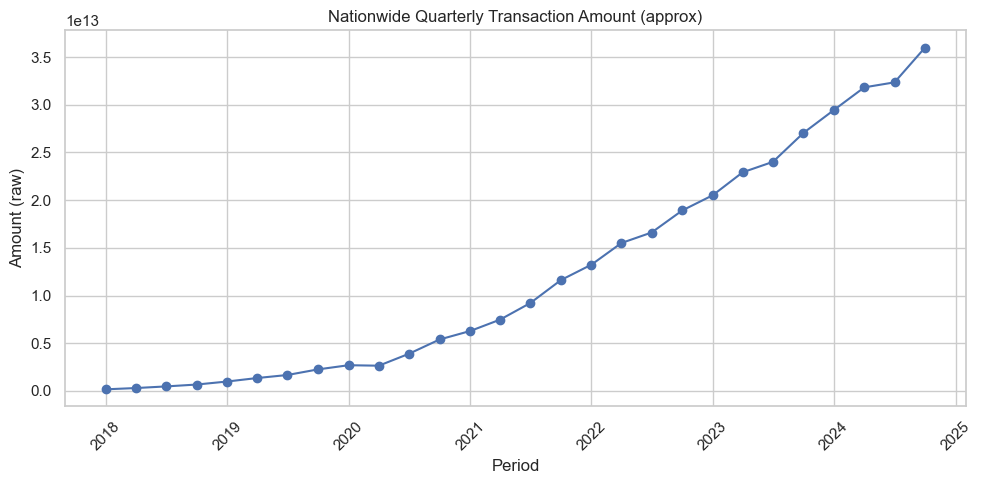

In [8]:
# Plot national quarterly amount trend (Matplotlib)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(nation_df['period'], nation_df['amount'], marker='o')
ax.set_title('Nationwide Quarterly Transaction Amount (approx)')
ax.set_xlabel('Period')
ax.set_ylabel('Amount (raw)')
plt.xticks(rotation=45)
plt.tight_layout()
fig_path = OUT_FIG / 'nation_quarterly_amount.png'
fig.savefig(fig_path, dpi=150)
print('Saved figure to', fig_path)
plt.show()

In [9]:
# Quick preview of the dataset
nation_df.head(10)

,file,year,quarter,amount,count,period
0,pulse\data\aggregated\transaction\country\indi...,2018,1,1.718343e+11,1.344262e+08,2018-01-01
1,pulse\data\aggregated\transaction\country\indi...,2018,2,3.043762e+11,1.873662e+08,2018-04-01
2,pulse\data\aggregated\transaction\country\indi...,2018,3,4.751059e+11,3.413012e+08,2018-07-01
3,pulse\data\aggregated\transaction\country\indi...,2018,4,6.717429e+11,4.171133e+08,2018-10-01
4,pulse\data\aggregated\transaction\country\indi...,2019,1,9.900302e+11,7.089961e+08,2019-01-01
5,pulse\data\aggregated\transaction\country\indi...,2019,2,1.354222e+12,8.153832e+08,2019-04-01
6,pulse\data\aggregated\transaction\country\indi...,2019,3,1.672565e+12,1.095012e+09,2019-07-01
7,pulse\data\aggregated\transaction\country\indi...,2019,4,2.259900e+12,1.460446e+09,2019-10-01
8,pulse\data\aggregated\transaction\country\indi...,2020,1,2.697120e+12,1.623040e+09,2020-01-01
9,pulse\data\aggregated\transaction\country\indi...,2020,2,2.646154e+12,1.448611e+09,2020-04-01


## Notes:
- The extraction heuristics are conservative; some files may not expose standard 'amount' fields and will yield NaN.
- If you want precise breakdowns (merchant vs P2P, state-level series), we can add tailored parsers once you confirm the exact JSON shapes or provide sample files.
- Next: add state-level examples, device charts, and seasonality heatmap (ask me to add these cells).

# Project: PhonePe Transaction Insights

**Skills takeaway:** Data Extraction, SQL Proficiency, Data Visualization, Analytical Thinking, Documentation, Streamlit

**Domain:** Finance / Payment Systems

## Problem Statement
With the increasing reliance on digital payment systems like PhonePe, understanding the dynamics of transactions, user engagement, and insurance-related data is crucial for improving services and targeting users effectively. This project aims to analyze and visualize aggregated values of payment categories, create maps for total values at state and district levels, and identify top-performing states, districts, and pin codes.

## Business Use Cases
- Customer Segmentation: Identify distinct user groups based on spending habits to tailor marketing strategies.
- Fraud Detection: Analyze transaction patterns to spot and prevent fraudulent activities.
- Geographical Insights: Understand payment trends at state and district levels for targeted marketing.
- Payment Performance: Evaluate the popularity of different payment categories for strategic investments.
- User Engagement: Monitor user activity to develop strategies that enhance retention and satisfaction.
- Product Development: Use data insights to inform the creation of new features and services.
- Insurance Insights: Analyze insurance transaction data to improve product offerings and customer experience.
- Marketing Optimization: Tailor marketing campaigns based on user behavior and transaction patterns.
- Trend Analysis: Examine transaction trends over time to anticipate demand fluctuations.
- Competitive Benchmarking: Compare performance against competitors to identify areas for improvement.

## Approach
1. Data Extraction: Clone the PhonePe Pulse repository and load relevant aggregated JSON files into analysis pipelines or a SQL database.
2. SQL Database & Table Creation: Create tables for aggregated and map/top datasets (Aggregated_user, Aggregated_transaction, Aggregated_insurance, Map_user, Map_map, Map_insurance, Top_user, Top_map, Top_insurance).
3. SQL Analysis: Build queries to extract business metrics and top performers.
4. Python Analysis: Use Pandas/Matplotlib/Seaborn to analyze query outputs and produce visualizations.
5. Dashboard: Build an interactive Streamlit app to present visualizations, filters and CSV downloads.
6. Insights & Recommendations: Summarize findings and provide actionable guidance.

## Deliverables
- Source code for data extraction, SQL queries, and Streamlit app.
- Documentation describing the approach, findings and how to run the project.
- Presentation slides summarizing key insights.

## Evaluation Metrics
- Code quality, SQL query efficiency, visualization clarity, insights relevance, documentation completeness.

## Timeline
Complete the project within 14 days from assignment.

---

*Reference links / resources were provided by the project owner and may be added to documentation as external references.*


In [ ]:
# Environment setup (safe checks)
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

print('Python version:', sys.version.split('\n')[0])
print('Pandas version:', pd.__version__)
print('Matplotlib version:', plt.matplotlib.__version__)

# Create output directories if missing (already created by earlier cells but safe to call)
from pathlib import Path
Path('analysis/results').mkdir(parents=True, exist_ok=True)
Path('analysis/figs').mkdir(parents=True, exist_ok=True)

# Next steps:
# 1) Run the earlier analysis cells to build nation_df and csv/fig outputs.
# 2) If you want, ask me to add state-level breakdowns, device charts, seasonality heatmap, or import the Colab notebook content.

In [ ]:
# Enhanced nation trend: rolling average and save enhanced CSV/PNG
if 'nation_df' in globals():
    df = nation_df.copy()
    df = df.set_index('period').resample('Q').sum()
    df['amount_ma4'] = df['amount'].rolling(window=4, min_periods=1).mean()
    out_csv = OUT_CSV / 'nation_quarterly_transactions_enhanced.csv'
    df.reset_index().to_csv(out_csv, index=False)
    print('Saved enhanced nation CSV to', out_csv)

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df['amount'], label='Amount', marker='o')
    ax.plot(df.index, df['amount_ma4'], label='4-Q MA', linestyle='--')
    ax.set_title('Nationwide Quarterly Transaction Amount with 4-Q MA')
    ax.set_xlabel('Period')
    ax.set_ylabel('Amount')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    fig_path = OUT_FIG / 'nation_quarterly_amount_enhanced.png'
    fig.savefig(fig_path, dpi=150)
    print('Saved enhanced nation figure to', fig_path)
    plt.show()
else:
    print('nation_df not found. Run the earlier cells to build nation_df first.')

In [ ]:
# Sample state analysis: Andhra Pradesh type-wise totals (aggregated across files)
STATE_SLUG = 'andhra_pradesh'  # folder name under transaction/state

def list_state_files(root, state_slug):
    pattern = Path(root) / 'transaction' / 'state' / state_slug / '*' / '*.json'
    return sorted(map(str, glob.glob(str(pattern))))

state_files = list_state_files(DATA_ROOT, STATE_SLUG)
print(f'Found {len(state_files)} files for state {STATE_SLUG}')

state_rows = []
for f in state_files:
    try:
        with open(f, 'r', encoding='utf-8') as fh:
            j = json.load(fh)
    except Exception as e:
        print('Failed to load', f, e)
        continue
    # look for breakdowns by "type" (merchant, peer-to-peer, etc.)
    # heuristic: search for dicts/lists containing 'name' and 'amount' keys
    def extract_types(x):
        out = []
        if isinstance(x, dict):
            if 'name' in x and any(k in x for k in ('amount','count')):
                amt = x.get('amount') or x.get('amt') or x.get('value')
                out.append((x.get('name'), safe_float(amt)))
            for v in x.values():
                out.extend(extract_types(v))
        elif isinstance(x, list):
            for item in x:
                out.extend(extract_types(item))
        return out

    types = extract_types(j)
    for name, amt in types:
        if name is None:
            continue
        state_rows.append({'file': f, 'type': str(name).strip(), 'amount': amt})

state_df = pd.DataFrame(state_rows)
if state_df.empty:
    print('No type-level data found for state; consider inspecting sample files in:', state_files[:3])
else:
    agg = state_df.groupby('type', dropna=True)['amount'].sum().reset_index().sort_values('amount', ascending=False)
    agg.to_csv(OUT_CSV / f'{STATE_SLUG}_type_totals.csv', index=False)
    print('Saved', OUT_CSV / f'{STATE_SLUG}_type_totals.csv')
    # Plot top 10 types
    topn = agg.head(10)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(topn['type'][::-1], topn['amount'][::-1])
    ax.set_title(f'Top transaction types in {STATE_SLUG.replace("_"," ").title()} (sum across files)')
    ax.set_xlabel('Amount')
    plt.tight_layout()
    fig_path = OUT_FIG / f'{STATE_SLUG}_type_totals.png'
    fig.savefig(fig_path, dpi=150)
    print('Saved figure to', fig_path)
    plt.show()

In [ ]:
# Device-brand pie chart (heuristic extraction across country-level user files)

def list_user_files(root):
    pattern = Path(root) / 'user' / 'country' / 'india' / '*' / '*.json'
    return sorted(map(str, glob.glob(str(pattern))))

user_files = list_user_files(DATA_ROOT)
print(f'Found {len(user_files)} country-level user files')

device_counts = {}

def extract_devices(x):
    # Heuristics: look for dicts or lists containing brand/count info
    if isinstance(x, dict):
        # common pattern: {'brand': 'X', 'count': 123}
        if 'brand' in x and any(k in x for k in ('count','value','percentage','total')):
            name = str(x.get('brand')).strip()
            cnt = safe_float(x.get('count') or x.get('value') or x.get('total'))
            device_counts[name] = device_counts.get(name, 0) + (0 if np.isnan(cnt) else cnt)
        else:
            for v in x.values():
                extract_devices(v)
    elif isinstance(x, list):
        for item in x:
            extract_devices(item)

# Parse user files until we have some device info
for f in user_files:
    try:
        with open(f, 'r', encoding='utf-8') as fh:
            j = json.load(fh)
    except Exception:
        continue
    extract_devices(j)

if not device_counts:
    print('No device-brand counts found with heuristics. You can inspect one user JSON for exact keys to adapt the parser.')
else:
    dev_df = pd.DataFrame([{'brand': k, 'count': v} for k,v in device_counts.items()])
    dev_df = dev_df.sort_values('count', ascending=False)
    dev_df.to_csv(OUT_CSV / 'device_brand_counts.csv', index=False)
    print('Saved device_brand_counts.csv')
    # Pie chart for top 8 brands
    top = dev_df.head(8)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.pie(top['count'], labels=top['brand'], autopct='%1.1f%%', startangle=140)
    ax.set_title('Top device brands (approx)')
    plt.tight_layout()
    fig_path = OUT_FIG / 'device_brand_pie.png'
    fig.savefig(fig_path, dpi=150)
    print('Saved device pie to', fig_path)
    plt.show()

## Business Case Studies (selected)
This notebook will produce findings for the following five case studies (chosen from your scenarios):

1. Transaction Dynamics: analyze quarterly trends and type-shares (merchant vs P2P etc.).
2. Device Dominance: identify device brands with high registrations but low engagement and plot brand counts.
3. Insurance Penetration: track insurance transaction amount and its share of total transactions over time and by state.
4. Market Expansion: top states by transaction value and a stacked breakdown by transaction type.
5. User Registration: top states/districts by registered users for selected year-quarter.

Each analysis saves CSV outputs under `analysis/results/` and PNGs under `analysis/figs/`. If any cell prints "not found" or yields empty outputs, run a sample-inspect cell (I can add one) and I'll adapt parsers to the exact JSON shapes.

In [ ]:
# Case Study 1: Transaction Dynamics — type shares over time (country-level)

# Heuristic: for each country-level transaction file, extract type breakdowns with 'name' and 'amount'
files = list_transaction_files(DATA_ROOT)
print('Transaction files:', len(files))
rows = []
for f in files:
    try:
        with open(f, 'r', encoding='utf-8') as fh:
            j = json.load(fh)
    except Exception as e:
        print('failed load', f)
        continue
    # find nested lists/dicts that look like type breakdowns
    def extract_types(x):
        out = []
        if isinstance(x, dict):
            if 'name' in x and any(k in x for k in ('amount','count','amt')):
                name = x.get('name')
                amt = x.get('amount') or x.get('amt') or x.get('value')
                out.append((name, safe_float(amt)))
            for v in x.values():
                out.extend(extract_types(v))
        elif isinstance(x, list):
            for item in x:
                out.extend(extract_types(item))
        return out

    types = extract_types(j)
    # derive year/quarter from path
    p = Path(f)
    try:
        year = int(p.parts[-2])
        quarter = int(Path(p.parts[-1]).stem)
        period = pd.to_datetime(f"{year}Q{quarter}")
    except Exception:
        period = None
    for tname, amt in types:
        if tname is None:
            continue
        rows.append({'period': period, 'type': str(tname).strip(), 'amount': amt})

txn_types_df = pd.DataFrame(rows)
if txn_types_df.empty:
    print('No type breakdowns found; adjust parser or inspect sample file.')
else:
    txn_types_df = txn_types_df.dropna(subset=['period']).copy()
    pivot = txn_types_df.pivot_table(index='period', columns='type', values='amount', aggfunc='sum').fillna(0)
    pivot.to_csv(OUT_CSV / 'transaction_type_timeseries.csv')
    print('Saved transaction_type_timeseries.csv')
    # compute shares
    shares = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)
    # plot stacked area for top types
    top_types = pivot.sum().sort_values(ascending=False).head(6).index.tolist()
    fig, ax = plt.subplots(figsize=(10,6))
    shares[top_types].plot.area(ax=ax)
    ax.set_title('Transaction Type Shares Over Time (top types)')
    ax.set_ylabel('Share')
    plt.tight_layout()
    fig_path = OUT_FIG / 'transaction_type_shares_area.png'
    fig.savefig(fig_path, dpi=150)
    print('Saved', fig_path)
    plt.show()

In [ ]:
# Case Study 2: Device Dominance — top brands bar chart (counts from device_brand_counts.csv or heuristics)
import os
csv_path = OUT_CSV / 'device_brand_counts.csv'
if csv_path.exists():
    dev_df = pd.read_csv(csv_path)
else:
    # fall back to device_counts built earlier in this session (if present)
    try:
        dev_df = dev_df
    except Exception:
        dev_df = pd.DataFrame()

if dev_df.empty:
    print('device_brand_counts.csv not found and no device data available. Run the device parsing cell first or inspect a user JSON.')
else:
    dev_df = dev_df.sort_values('count', ascending=False).head(12)
    dev_df.to_csv(OUT_CSV / 'device_brand_top12.csv', index=False)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(dev_df['brand'], dev_df['count'])
    ax.set_title('Top device brands by count')
    ax.set_ylabel('Count')
    ax.set_xticklabels(dev_df['brand'], rotation=45, ha='right')
    plt.tight_layout()
    fig_path = OUT_FIG / 'device_brand_top12.png'
    fig.savefig(fig_path, dpi=150)
    print('Saved device brand top12 figure to', fig_path)
    plt.show()

In [ ]:
# Case Study 3: Insurance Penetration — insurance amount vs total transaction amount (country-level and attempt per-state)
# Country-level: read insurance country files and transaction country files and compute share over time
ins_files = sorted(glob.glob(str(Path(DATA_ROOT) / 'insurance' / 'country' / 'india' / '*' / '*.json')))
txn_files = list_transaction_files(DATA_ROOT)

def extract_amount_from_country_files(file_list):
    rows = []
    for f in file_list:
        try:
            with open(f, 'r', encoding='utf-8') as fh:
                j = json.load(fh)
        except Exception:
            continue
        amt, cnt = extract_transaction_totals(j)
        p = Path(f)
        try:
            year = int(p.parts[-2])
            quarter = int(Path(p.parts[-1]).stem)
            period = pd.to_datetime(f"{year}Q{quarter}")
        except Exception:
            period = None
        rows.append({'period': period, 'amount': amt})
    return pd.DataFrame(rows)

ins_df = extract_amount_from_country_files(ins_files)
txn_df = extract_amount_from_country_files(txn_files)
if ins_df.empty or txn_df.empty:
    print('Insurance or transaction country-level files not found or failed to parse.')
else:
    # aggregate by period
    ins_sum = ins_df.dropna(subset=['period']).groupby('period')['amount'].sum()
    txn_sum = txn_df.dropna(subset=['period']).groupby('period')['amount'].sum()
    merged = pd.DataFrame({'insurance_amount': ins_sum, 'transaction_amount': txn_sum}).fillna(0)
    merged['insurance_share'] = merged['insurance_amount'] / merged['transaction_amount'].replace({0: np.nan})
    merged = merged.fillna(0)
    merged.reset_index().to_csv(OUT_CSV / 'insurance_vs_txn_timeseries.csv', index=False)
    print('Saved insurance_vs_txn_timeseries.csv')
    # plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(merged['period'], merged['insurance_amount'], label='Insurance amount')
    ax.plot(merged['period'], merged['transaction_amount'], label='Transaction amount')
    ax.set_title('Insurance vs Transaction Amount (country-level)')
    ax.legend()
    plt.tight_layout()
    fig_path = OUT_FIG / 'insurance_vs_txn_timeseries.png'
    fig.savefig(fig_path, dpi=150)
    print('Saved', fig_path)
    plt.show()

# Attempt per-state insurance penetration (if state-level insurance files exist)
state_ins_pattern = Path(DATA_ROOT) / 'insurance' / 'state' / '*' / '*' / '*.json'
state_ins_files = sorted(map(str, glob.glob(str(state_ins_pattern))))
state_txn_pattern = Path(DATA_ROOT) / 'transaction' / 'state' / '*' / '*' / '*.json'
state_txn_files = sorted(map(str, glob.glob(str(state_txn_pattern))))

if state_ins_files and state_txn_files:
    # aggregate by state across all files
    state_rows = {}
    for f in state_ins_files:
        p = Path(f)
        state = p.parts[-4] if len(p.parts) >= 4 else 'unknown'
        try:
            with open(f, 'r', encoding='utf-8') as fh:
                j = json.load(fh)
        except Exception:
            continue
        amt, _ = extract_transaction_totals(j)
        state_rows[state] = state_rows.get(state, 0) + (amt or 0)
    state_txn_rows = {}
    for f in state_txn_files:
        p = Path(f)
        state = p.parts[-4] if len(p.parts) >= 4 else 'unknown'
        try:
            with open(f, 'r', encoding='utf-8') as fh:
                j = json.load(fh)
        except Exception:
            continue
        amt, _ = extract_transaction_totals(j)
        state_txn_rows[state] = state_txn_rows.get(state, 0) + (amt or 0)
    # merge
    st_df = pd.DataFrame([{'state': s, 'insurance_amount': state_rows.get(s,0), 'transaction_amount': state_txn_rows.get(s,0)} for s in set(list(state_rows.keys())+list(state_txn_rows.keys()))])
    st_df['penetration'] = st_df['insurance_amount'] / st_df['transaction_amount'].replace({0: np.nan})
    st_df = st_df.fillna(0).sort_values('penetration', ascending=False)
    st_df.to_csv(OUT_CSV / 'state_insurance_penetration.csv', index=False)
    print('Saved state_insurance_penetration.csv')
    # plot top 15 by penetration
    top = st_df.head(15).sort_values('penetration')
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(top['state'], top['penetration'])
    ax.set_title('Top 15 States by Insurance Penetration (insurance_amt / txn_amt)')
    plt.tight_layout()
    fig_path = OUT_FIG / 'state_insurance_penetration.png'
    fig.savefig(fig_path, dpi=150)
    print('Saved', fig_path)
    plt.show()
else:
    print('State-level insurance or transaction files not found; per-state penetration skipped.')

In [ ]:
# Case Study 4: Market Expansion — top states by transaction amount and stacked breakdown (top states)
# Aggregate state-level transaction amounts across files
state_pattern = Path(DATA_ROOT) / 'transaction' / 'state' / '*' / '*' / '*.json'
state_files = sorted(map(str, glob.glob(str(state_pattern))))
print('Found state transaction files:', len(state_files))
state_sums = {}
state_type_break = {}
for f in state_files:
    p = Path(f)
    # state slug should be 3rd-from-end: .../state/<state_slug>/<year>/<q>.json -> parts[-3]
    if len(p.parts) >= 3:
        state = p.parts[-3]
    else:
        state = 'unknown'
    try:
        with open(f, 'r', encoding='utf-8') as fh:
            j = json.load(fh)
    except Exception:
        continue
    amt, _ = extract_transaction_totals(j)
    state_sums[state] = state_sums.get(state, 0) + (amt or 0)
    # try to extract type breakdowns
    def extract_types_dict(x):
        out = []
        if isinstance(x, dict):
            if 'name' in x and any(k in x for k in ('amount','amt')):
                out.append((x.get('name'), safe_float(x.get('amount') or x.get('amt'))))
            for v in x.values():
                out.extend(extract_types_dict(v))
        elif isinstance(x, list):
            for item in x:
                out.extend(extract_types_dict(item))
        return out
    types = extract_types_dict(j)
    for tname, tamt in types:
        if tname is None:
            continue
        key = (state, str(tname).strip())
        state_type_break[key] = state_type_break.get(key, 0) + (tamt or 0)

state_df = pd.DataFrame([{'state': s, 'amount': a} for s,a in state_sums.items()]).sort_values('amount', ascending=False)
state_df.to_csv(OUT_CSV / 'states_total_txn_amounts.csv', index=False)
print('Saved states_total_txn_amounts.csv')
# plot top 12 states
top_states = state_df.head(12)['state'].tolist()
# build stacked dataframe
rows = []
for (st, t), val in state_type_break.items():
    if st in top_states:
        rows.append({'state': st, 'type': t, 'amount': val})
stack_df = pd.DataFrame(rows)
if stack_df.empty:
    print('No type breakdown by state found for top states; stacked breakdown skipped.')
else:
    pivot = stack_df.pivot_table(index='state', columns='type', values='amount', aggfunc='sum').fillna(0)
    pivot = pivot.loc[top_states]
    pivot.to_csv(OUT_CSV / 'top_states_type_breakdown.csv')
    # stacked bar
    fig, ax = plt.subplots(figsize=(12,8))
    pivot.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title('Top states by transaction amount (stacked by type)')
    plt.tight_layout()
    fig_path = OUT_FIG / 'top_states_stacked_types.png'
    fig.savefig(fig_path, dpi=150)
    print('Saved', fig_path)
    plt.show()

In [ ]:
# Case Study 5: User Registration Analysis — top states by registered users for a selected year-quarter
# Heuristic: look in user/state files for registration counts
YEAR = 2020
QUARTER = 1
pattern = Path(DATA_ROOT) / 'user' / 'state' / '*' / str(YEAR) / f'{QUARTER}.json'
files = sorted(map(str, glob.glob(str(pattern))))
print('User state files for', YEAR, 'Q', QUARTER, 'found:', len(files))
rows = []
for f in files:
    p = Path(f)
    state = p.parts[-4] if len(p.parts) >= 4 else 'unknown'
    try:
        with open(f, 'r', encoding='utf-8') as fh:
            j = json.load(fh)
    except Exception:
        continue
    # look for keys like 'registeredUsers', 'count', 'registered'
    def find_registered(x):
        if isinstance(x, dict):
            for k,v in x.items():
                if 'register' in str(k).lower() or k.lower() in ('count','registeredusers','registered'):
                    return safe_float(v)
                r = find_registered(v)
                if r is not None:
                    return r
        elif isinstance(x, list):
            for it in x:
                r = find_registered(it)
                if r is not None:
                    return r
        return None
    reg = find_registered(j)
    rows.append({'state': state, 'registered': reg or 0})
reg_df = pd.DataFrame(rows).groupby('state', as_index=False)['registered'].sum().sort_values('registered', ascending=False)
reg_df.to_csv(OUT_CSV / f'user_registrations_{YEAR}_Q{QUARTER}.csv', index=False)
print('Saved user registrations CSV')
# plot top 15
top = reg_df.head(15)
if not top.empty:
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(top['state'][::-1], top['registered'][::-1])
    ax.set_title(f'Top 15 states by registered users ({YEAR} Q{QUARTER})')
    plt.tight_layout()
    fig_path = OUT_FIG / f'user_registrations_{YEAR}_Q{QUARTER}.png'
    fig.savefig(fig_path, dpi=150)
    print('Saved', fig_path)
    plt.show()
else:
    print('No registration data found for the selected year-quarter; try a different year/quarter or inspect sample files.')